# <span style="color:orange">**Model Training**</span>

### **Train a LigthGBM model to forecast outages 6 hours ahead.**

#### <u>Data used for training:</u>
- Output of notebook `'Prepare Complete Dataset'` from **2019-01-01 to 2023-10-31** (~5 years, ~16,000,000 rows).
- 127 features.
- All counties of Eaglei dataset.
- An under-sampling strategy has been used to avoid training on an excessive number of rows, most of them having zero outages (~95%). Only 10% of these have been, kept, while 80% of non-null outages have been kept.
  
#### <u>Data used for inference:</u>
- Output of notebook `'Prepare Complete Dataset'` from **2023-11-01 to 2023-12-31** (2 months, ~4,270,000 rows).

#### <u>Model used: **Single LightGBM** for time-series (regression).</u>  
- **Efficiency**: Chosen for its strong performance on tabular time series tasks — consistently ranks high in forecasting challenges.  
- **Rapidity**: Fast training with multi-CPU setups, quick inference, and low resource usage — ideal for rapid experimentation and iteration.  
- **Feature-rich**: Easily integrates exogenous variables (e.g. weather, location), essential for accurate outage prediction.  
- **Simplicity**: A single model ensures scalability and robustness in production. Ensembling brought only marginal gains, not worth the added complexity or cost.  
- **Interpretability**: Feature importance metrics provide actionable insights, enhancing trust and explainability.

#### <u>Cross-validation, model parameters and features selection:</u>
- This notebook includes an optionnal cross-validation step: a model is trained several times with a **temporal train/test split** on periods [p1, p2], and is evaluated on periods [p2+1day, p2+4months].
-  This cross-validation strategy simulates **real life forecasts**. It was used to select **best features** and **best model parameters**.
-  **Best features** have been selected with a **backward feature elimination** strategy.
-  **Best model parameters** have been selected with **optuna**.
-  To run the cross-validation part, set `'evaluate_model_with_cross_validation'` to `True`.


#### <u>Custom metrics & Model objective:</u>
-  **2 custom metrics** have been designed to evaluate model performance on rare events such as massive outages peaks.
-  These metrics are **more relevant than standard ones**, especially `Mean Absolute Error (MAE)`, which tends to push the model toward forecasting very low outage values. In fact, predicting only zeros is a surprisingly strong baseline for optimizing MAE!
-  However, the best results were obtained by training on `RMSE` rather than on either of the two custom metrics. This can be explained by the fact that LightGBM is optimized for RMSE, whereas our custom metrics are non-differentiable (and non-convex).
-  **<u>Custom metric n°1:</u>**
    - `custom_metric`
    - A variant of RMSE with two modifications: it under-penalizes overestimations a few hours before peaks and over-penalizes underestimations during peaks..
    - The idea is that forecasting major outages a few hours too early is less problematic than predicting them a few hours too late.
-  **<u>Custom metric n°2:</u>**
    - `custom_peak_Fbeta_score`
    - An **Fβ-score** with β=2 (**favoring Recall**). This metric evaluates whether predictions correctly identify major outage outbreaks occurring within the period [current_hour + 4 hours, current_hour + 12 hours].
    - It balances **Recall** (important because missing an outbreak is very costly) and **Precision** (important because false alarms are also costly).


**At the end of the notebook, a model is trained on all data.**

In [1]:
# If true, evaluate model by running the corss-validation step with temporal train/test split.
# If False, skip this step and goes directly to real training phase (on all data).
evaluate_model_with_cross_validation = True

___
___
# **Librairies**

In [3]:
from utility_script_dynamic_rythms import *

___
___
# **Open Data**

### **Optimized column types (to save memory)**

### **Open CSV and concat them in a single df**
> - To avoid memory issues, I created several df from notebook `2. Prepare Dataset`.
> - I then concatenated them to train the model on a single one, with data from all counties from 2019-01-01 to 2023-10-31.
> - If you want to train on a single df output by the notebook `2. Prepare Dataset`, please just run the "except" part in the code below.

In [4]:
%%time

# -------------------------------------------------------------------------------------------------
# IGNORE THE "TRY" PART IF YOU DONT WANT TO RE-CREATE A TRAIN DATASET FROM SUB-DATASETS (chunks)
try :

    # CSV paths
    dirpath = "/kaggle/input/tow-train-new/"
    paths = sorted([dirpath+x for x in os.listdir(dirpath)])

    # Columns to use
    usecols = pd.read_csv(paths[0], nrows=1).columns
    
    # Read CSVs and concatenate them into one single df
    df = pd.concat([pd.read_csv(path, dtype=dtypes, usecols=usecols) for path in tqdm(paths, position=0, leave=True)])

# -------------------------------------------------------------------------------------------------
# USE THIS PART IF YOU WANT TO USE THE OUTPUT FROM NOTEBOOK "2. Prepare Dataset" AS TRAIN DATASET
except :
    
    # Read CSV - output from notebook `2. Prepare Dataset`
    df = pd.read_csv(filepath_to_train_dataset, dtype=dtypes, usecols=usecols)

    
# Show
print(df.shape)
df.head(1)

  0%|          | 0/33 [00:00<?, ?it/s]

  3%|▎         | 1/33 [00:19<10:17, 19.31s/it]

  6%|▌         | 2/33 [00:31<07:50, 15.17s/it]

  9%|▉         | 3/33 [00:42<06:42, 13.42s/it]

 12%|█▏        | 4/33 [01:01<07:26, 15.40s/it]

 15%|█▌        | 5/33 [01:14<06:52, 14.73s/it]

 18%|█▊        | 6/33 [01:26<06:05, 13.54s/it]

 21%|██        | 7/33 [01:37<05:34, 12.86s/it]

 24%|██▍       | 8/33 [01:49<05:16, 12.66s/it]

 27%|██▋       | 9/33 [02:07<05:42, 14.28s/it]

 30%|███       | 10/33 [02:18<05:04, 13.23s/it]

 33%|███▎      | 11/33 [02:28<04:28, 12.22s/it]

 36%|███▋      | 12/33 [02:44<04:44, 13.52s/it]

 39%|███▉      | 13/33 [02:54<04:05, 12.29s/it]

 42%|████▏     | 14/33 [03:03<03:36, 11.40s/it]

 45%|████▌     | 15/33 [03:17<03:37, 12.09s/it]

 48%|████▊     | 16/33 [03:30<03:28, 12.24s/it]

 52%|█████▏    | 17/33 [03:41<03:11, 11.98s/it]

 55%|█████▍    | 18/33 [03:52<02:54, 11.63s/it]

 58%|█████▊    | 19/33 [04:09<03:07, 13.36s/it]

 61%|██████    | 20/33 [04:19<02:41, 12.46s/it]

 64%|██████▎   | 21/33 [04:28<02:16, 11.39s/it]

 67%|██████▋   | 22/33 [04:40<02:05, 11.39s/it]

 70%|██████▉   | 23/33 [04:55<02:05, 12.59s/it]

 73%|███████▎  | 24/33 [05:05<01:45, 11.71s/it]

 76%|███████▌  | 25/33 [05:18<01:36, 12.06s/it]

 79%|███████▉  | 26/33 [05:35<01:35, 13.62s/it]

 82%|████████▏ | 27/33 [05:44<01:12, 12.15s/it]

 85%|████████▍ | 28/33 [05:58<01:03, 12.68s/it]

 88%|████████▊ | 29/33 [06:12<00:52, 13.14s/it]

 91%|█████████ | 30/33 [06:22<00:36, 12.17s/it]

 94%|█████████▍| 31/33 [06:32<00:23, 11.56s/it]

 97%|█████████▋| 32/33 [06:44<00:11, 11.76s/it]

100%|██████████| 33/33 [06:59<00:00, 12.76s/it]

100%|██████████| 33/33 [06:59<00:00, 12.72s/it]

(16032951, 144)
CPU times: user 3min 56s, sys: 1min 10s, total: 5min 6s
Wall time: 7min 3s


,fips,date,month,week,dayofweek,hour,outages,outages_outbreak,Proportion_of_fips_within_300km_with_more_than_50_outages,Proportion_of_fips_within_600km_with_more_than_50_outages,...,Biggest_raise_of_outages_over_last_6h,DIFF_outages_from_24hours_ago,Biggest_raise_of_outages_over_last_24h,DIFF_outages_outbreak,DIFF_outages_outbreak_from_6hours_ago,Biggest_raise_of_outages_outbreak_over_last_6h,DIFF_outages_outbreak_from_24hours_ago,Biggest_raise_of_outages_outbreak_over_last_24h,outages_in_6hours,outages_outbreak_in_6hours
0,21131,2023-07-03,7,27.0,0,3,4.0,4,0.3914,0.2827,...,1.0,-235.0,56.0,4.0,4.0,4.0,1.204236,4.0,53.0,53.0


### **Data Preparation**
> - Optimize data types to save memory
> - Drop missing targets
> - Drop potential duplicates
> - Sort values by fips and date (optionnal)
> - Convert `fips code` and `state` to categorical columns

In [5]:
# Reduce memory usage of df by further optimizing dtypes
df = reduce_memory_usage(df)

BEFORE: Memory usage of dataframe is 10932.50 MB


AFTER: Memory usage became:  5947.9  MB


In [6]:
# Drop duplicates
df = df.drop_duplicates(subset = ['fips', 'date', 'hour'], keep='first').reset_index(drop=True)

# Sort values
df = df.sort_values(by = ['fips', 'date', 'hour']).reset_index(drop=True)

# Convert fips and state as categories
for k in ['state', 'fips']:
    df[k] = df[k].astype('category')

# Show
print(df.shape)
df.head(1)

(16032010, 144)


,fips,date,month,week,dayofweek,hour,outages,outages_outbreak,Proportion_of_fips_within_300km_with_more_than_50_outages,Proportion_of_fips_within_600km_with_more_than_50_outages,...,Biggest_raise_of_outages_over_last_6h,DIFF_outages_from_24hours_ago,Biggest_raise_of_outages_over_last_24h,DIFF_outages_outbreak,DIFF_outages_outbreak_from_6hours_ago,Biggest_raise_of_outages_outbreak_over_last_6h,DIFF_outages_outbreak_from_24hours_ago,Biggest_raise_of_outages_outbreak_over_last_24h,outages_in_6hours,outages_outbreak_in_6hours
0,1001,2019-01-01,1,1.0,1,12,3.0,0,0.052032,0.028152,...,3.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,1.0,0.0


In [7]:
# Model target
target = 'outages_in_6hours'

# Drop row with missing target
df = df[~df[target].isna()].reset_index(drop=True)

### **Display some information about training data**

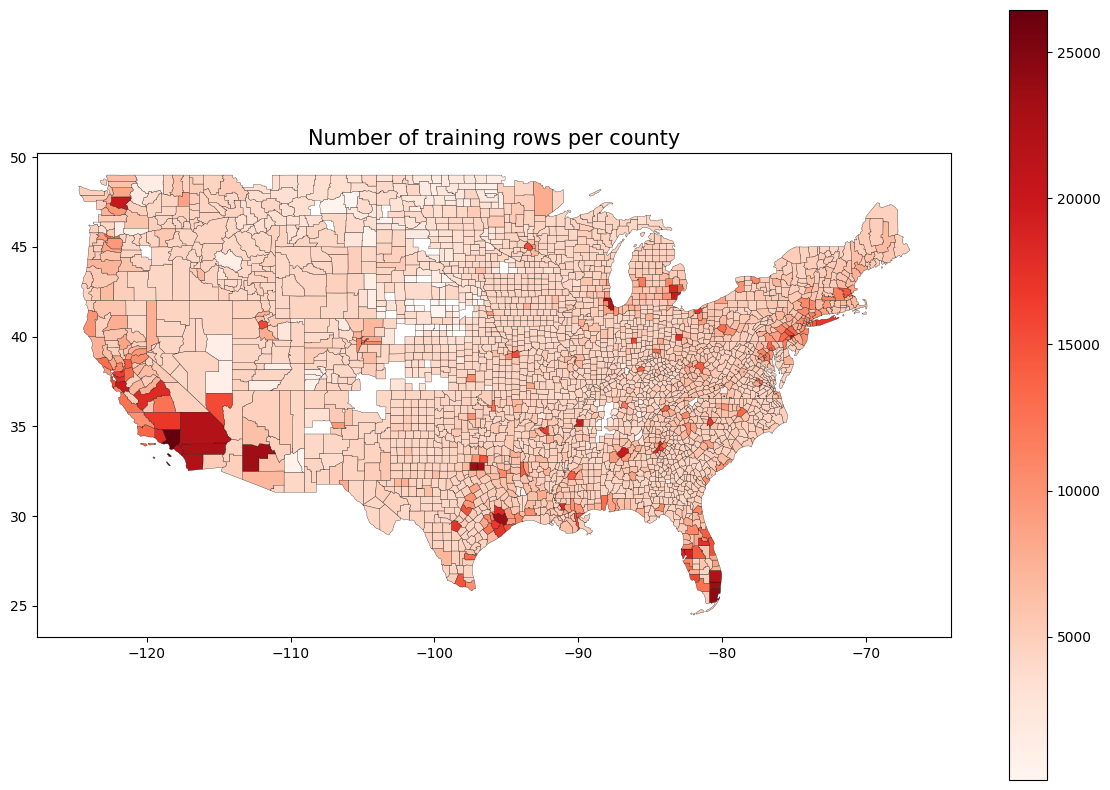

In [8]:
# Show number of rows by fips
stats = df.groupby('fips')['date'].count().to_frame().reset_index().rename(columns =  {'date' : 'count'})
plot_fips_on_map(stats, color_col='count', title='Number of training rows per county')

___
___
# **Model Features and Parameters**
-  **Best features** have been selected with a **backward feature elimination** strategy.
-  **Best model parameters** have been selected with **optuna**.
-  To run the cross-validation part, set `'evaluate_model_with_cross_validation'` to `True` at the start of the notebook.

In [9]:
# RMSE. Don't use MAE, or it will prefer to predict low values
objective = "regression"

# We will use early-stopping with our custom metric, not RMSE
fit_params = {"eval_metric" : [custom_metric]}

# Parameters found with optuna
model_params = {'objective': objective,
                'verbosity': -1,
                'boosting_type': 'gbdt',
                'random_state': 12,
                'n_jobs': max(1, os.cpu_count()-1),
                'n_estimators': 200,
                'learning_rate': 0.0536,
                'max_depth': 13,
                'reg_alpha': 2.33,
                'reg_lambda': 0.212,
                'colsample_bytree': 0.63,
                'subsample': 0.7,
                'min_child_samples': 6,
                'num_leaves': 380,
               }

In [10]:
feats = ['dayofweek',
         'week',
         'hour',
         'month',
         'fips',
         'latitude',
         'longitude',
         'state',
         'Population',
         'LandArea',
         'WaterArea',
         'Population_sum_among_1st_neighbours',
         'Population_sum_among_2nd_neighbours',
         'Population_sum_among_3rd_neighbours',
         'Population_sum_among_4th_neighbours',
         'Population_sum_among_ALL_neighbours',
         'Age',
         'Biggest_raise_of_outages_outbreak_over_last_6h',
         'Biggest_raise_of_outages_outbreak_over_last_24h',
         'Biggest_raise_of_outages_over_last_6h',
         'Biggest_raise_of_outages_over_last_24h',
         'DIFF_outages',
         'DIFF_outages_from_6hours_ago',
         'DIFF_outages_from_24hours_ago',
         'DIFF_outages_outbreak',
         'DIFF_outages_outbreak_from_6hours_ago',
         'DIFF_outages_outbreak_from_24hours_ago',
         'Max_of_MAGNITUDE_sum_among_1st_neighbours_over_last_12hours',
         'Max_of_MAGNITUDE_sum_among_2nd_neighbours_over_last_12hours',
         'Max_of_outages_over_last_12hours',
         'Max_of_outages_over_last_36hours',
         'Max_of_outages_sum_among_1st_neighbours_over_last_12hours',
         'Max_of_outages_sum_among_2nd_neighbours_over_last_12hours',
         'Severe_events_count',
         'Sum_of_Severe_events_count_sum_among_1st_neighbours_over_last_6hours',
         'Sum_of_Severe_events_count_sum_among_2nd_neighbours_over_last_6hours',
         'Sum_of_Severe_events_count_sum_among_ALL_neighbours_over_last_6hours',
         'Sum_of_Severe_events_count_sum_among_1st_neighbours_over_last_24hours',
         'Sum_of_Severe_events_count_sum_among_2nd_neighbours_over_last_24hours',
         'Sum_of_Severe_events_count_sum_among_ALL_neighbours_over_last_24hours',
         'Sum_of_WORDS_downed_trees_sum_among_ALL_neighbours_over_last_24hours',
         'Sum_of_WORDS_downed_trees_sum_among_ALL_neighbours_over_last_6hours',
         'Sum_of_WORDS_wind_and_storm_sum_among_ALL_neighbours_over_last_24hours',
         'Sum_of_WORDS_wind_and_storm_sum_among_ALL_neighbours_over_last_6hours',
         'Sum_of_WORDS_wires_sum_among_ALL_neighbours_over_last_24hours',
         'Sum_of_WORDS_wires_sum_among_ALL_neighbours_over_last_6hours',
         'WORDS_downed_trees_sum_among_ALL_neighbours',
         'WORDS_heavy_damage_sum_among_ALL_neighbours',
         'WORDS_wind_and_storm_sum_among_ALL_neighbours',
         'WORDS_wires_sum_among_ALL_neighbours',
         'WORDS_heat_and_fire_sum_among_ALL_neighbours',


         # Outages and outages outbreaks
         'outages',
         'outages_outbreak',
         'outages_outbreak_sum_among_1st_neighbours',
         'outages_outbreak_sum_among_2nd_neighbours',
         'outages_outbreak_sum_among_3rd_neighbours',
         'outages_outbreak_sum_among_4th_neighbours',
         'outages_outbreak_sum_among_ALL_neighbours',
         'outages_sum_among_1st_neighbours',
         'outages_sum_among_2nd_neighbours',
         'outages_sum_among_3rd_neighbours',
         'outages_sum_among_4th_neighbours',
         'outages_sum_among_ALL_neighbours',
         'Max_of_outages_sum_among_1st_neighbours_over_last_36hours',
         'Max_of_outages_sum_among_2nd_neighbours_over_last_36hours',
         'Max_of_outages_sum_among_ALL_neighbours_over_last_36hours',
         'Max_of_outages_sum_among_ALL_neighbours_over_last_12hours',

         # Projection of where outages fronts will hit in 3 and 6 hours
         'projected_distance_to_centroid_center_in_3hours',
         'projected_distance_to_centroid_center_in_6hours',
         'projected_fips_impacted_in_3hours',
         'projected_fips_impacted_in_6hours',
         'projected_impact_in_3hours',
         'projected_impact_in_6hours',
         'vector_cluster_size',
         'vector_cluster_size_diff',
         'vector_weights',
         'vector_weights_diff',
         'DIFF_vector_weights',

         # Daily temperature and max wind speed
         'Temperature_1day_before',
         'MaxWindSpeed_1day_before',
         'Max_Temperature_over_3last_days',
         'Mean_Temperature_over_3last_days',
         'Max_MaxWindSpeed_over_3last_days',
         'Mean_MaxWindSpeed_over_3last_days',
         'Temperature_1day_before_std_among_1st_neighbours',
         'Temperature_1day_before_std_among_2nd_neighbours',
         'Temperature_1day_before_std_among_3rd_neighbours',
         'Temperature_1day_before_std_among_4th_neighbours',
         
         # Wind magnitude
         'MAGNITUDE',
         'MAGNITUDE_sum_among_1st_neighbours',
         'MAGNITUDE_sum_among_2nd_neighbours',

         # Proportion of close fips with high outages (more than 50)
         'Proportion_of_fips_within_300km_with_more_than_50_outages',
         'Proportion_of_fips_within_600km_with_more_than_50_outages',
         'max_Proportion_of_fips_within_300km_with_more_than_50_outages_over_last_24hours',
         'max_Proportion_of_fips_within_600km_with_more_than_50_outages_over_last_24hours',

         # State features
         'SUM_BY_STATE_Severe_events_count_sum_by_state_last_24hours',
         'SUM_BY_STATE_WORDS_wind_and_storm_sum_by_state_last_24hours',
         'SUM_BY_STATE_WORDS_downed_trees_sum_by_state_last_24hours',
         'SUM_BY_STATE_WORDS_heavy_damage_sum_by_state_last_24hours',
         'SUM_BY_STATE_WORDS_wires_sum_by_state_last_24hours',
         'SUM_BY_STATE_state_fips_with_more_than_50_outages_last_24hours',
         'max_state_fips_with_more_than_50_outages_over_last_6hours',
         'max_state_fips_with_more_than_50_outages_over_last_24hours',
         'proportion_state_fips_with_more_than_50_outages_over_last_6hours',
         'proportion_state_fips_with_more_than_50_outages_over_last_24hours',
         'Count_Other_moderate_sum_by_state',
         'Count_Other_severe_sum_by_state',
         'Count_Flood_sum_by_state',
         'Count_Storm_sum_by_state',
         'Count_Wind_sum_by_state',
         
         # Severe weather event counts along neighbours
         'Severe_events_count_sum_among_1st_neighbours',
         'Severe_events_count_sum_among_2nd_neighbours',
         'Severe_events_count_sum_among_3rd_neighbours',
         'Severe_events_count_sum_among_4th_neighbours',
         'Severe_events_count_sum_among_ALL_neighbours',

         # Count of weather events (storm data)
         'Count_Wind',
         'Count_Flood',
         'Count_Other_moderate_sum_among_ALL_neighbours',
         'Count_Flood_sum_among_ALL_neighbours',
         'Count_Storm_sum_among_ALL_neighbours',
         'Count_Wind_sum_among_ALL_neighbours',
         'Max_of_Severe_events_count_over_last_6hours',
         'Max_of_Severe_events_count_sum_among_ALL_neighbours_over_last_6hours',
         'Max_of_Count_Other_moderate_sum_among_ALL_neighbours_over_last_6hours',
         'Max_of_Count_Flood_sum_among_ALL_neighbours_over_last_6hours',
         'Max_of_Count_Storm_sum_among_ALL_neighbours_over_last_6hours',
         'Max_of_Count_Wind_sum_among_ALL_neighbours_over_last_6hours',
         
        ]

# Print information
print(f"Features : {len(feats)}.\n")
print(df[feats].shape)
df[feats].head(1)

Features : 127.



(15964908, 127)


,dayofweek,week,hour,month,fips,latitude,longitude,state,Population,LandArea,...,Count_Other_moderate_sum_among_ALL_neighbours,Count_Flood_sum_among_ALL_neighbours,Count_Storm_sum_among_ALL_neighbours,Count_Wind_sum_among_ALL_neighbours,Max_of_Severe_events_count_over_last_6hours,Max_of_Severe_events_count_sum_among_ALL_neighbours_over_last_6hours,Max_of_Count_Other_moderate_sum_among_ALL_neighbours_over_last_6hours,Max_of_Count_Flood_sum_among_ALL_neighbours_over_last_6hours,Max_of_Count_Storm_sum_among_ALL_neighbours_over_last_6hours,Max_of_Count_Wind_sum_among_ALL_neighbours_over_last_6hours
0,1,1.0,12,1,1001,32.53125,-86.625,AL,58255.0,1540.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


___
___
# **Model training & Evaluation**
> - This part is **not** the real training phase.
> - Its purpose is to perform a temporal-split validation scheme : we train on several period [p1, p2] and we validate on [p2+1day, p2+4months].
> - The idea is to evaluate the stability of the model and its results on different periods (summer, winter...).
> - Finally, this part was used to select best features and best model parameters (optuna).

In [11]:
%%time

if evaluate_model_with_cross_validation :
    
    # DATES
    DATE_START_TRAIN = '2022-06-01' # Training will start on period [date_min, DATE_START_TRAIN]
    DATE_END_TRAIN   = '2023-06-01' # Date until which we will train
    NDAYS_RETRAIN    = 119 # Number of days before re-training (better if divisible by 7, for complete weeks). Here, approximately 4 months.
    first_date_eval  = str(pd.to_datetime(DATE_START_TRAIN) + pd.DateOffset(days = 1))[:10] # DATE_START_TRAIN + NDAYS_RETRAIN
    
    # Info sur les données de train/test
    print('\n' + "#"*60)
    print(f"Train  : {DATE_START_TRAIN} => {DATE_END_TRAIN}.")
    print(f"Re-training every {NDAYS_RETRAIN} days.")
    print("#"*60)
    
    # Feature Importance
    Feature_Imp = None
    
    #######################################################################################################################################################
    # INITIALIZATION
        
    # Initialize dates that will be used for train and test index
    date_start_train = DATE_START_TRAIN
    eval_date_start  = first_date_eval
    eval_date_end    = str(pd.to_datetime(first_date_eval) + pd.DateOffset(days = NDAYS_RETRAIN))[:10] # first_date_eval + NDAYS_RETRAIN
    
    #######################################################################################################################################################
    # TRAINING LOOP
    while (date_start_train == DATE_START_TRAIN) or (len(df[test_idx]) >= NDAYS_RETRAIN): # 1st condition to make sure the loop is executed at least one time
        
        # -------------------------------------------------------------------------------------------------------------------------------------------------
        # Create Train & Test splits
    
        # Define index for temporal Train/Test split
        train_idx = (df['date'] <= date_start_train)
        test_idx  = (df['date'].between(eval_date_start, eval_date_end))
    
        # Train/Test split
        xtr, ytr = df.loc[train_idx, feats], df.loc[train_idx, target]
        xte, yte = df.loc[test_idx, feats] , df.loc[test_idx, target]
    
        # Stop condition
        if (len(xtr)==0) or (len(xte) < 50000) : break
    
        # Print info
        print('\n' + '='*60)
        train_period = f"{df.loc[train_idx, 'date'].astype(str).min()} => {df.loc[train_idx, 'date'].astype(str).max()}"
        test_period  = f"{df.loc[test_idx, 'date'].astype(str).min()} => {df.loc[test_idx, 'date'].astype(str).max()}"
        print(f"Train : {train_period} ({str(len(df[train_idx])).ljust(4)} rows).")
        print(f"Test  : {test_period} ({str(len(df[test_idx])).ljust(4)} rows).")
        print()
        
        # -------------------------------------------------------------------------------------------------------------------------------------------------
        # Model Training
    
        # Create model
        model = lgb.LGBMRegressor(**model_params)
        
        # Update fit parameters
        fit_params["eval_set"] = [(xte, yte)]
    
        # Fit model
        model.fit(xtr, ytr,
                  **fit_params,
                  callbacks = [#lgb.early_stopping(stopping_rounds=100, first_metric_only=True),
                               lgb.log_evaluation(50)])
    
        # ---------------------------------------
        # Save predictions and compute metrics
    
        # Compute predictions
        preds = np.clip(model.predict(xte), 0, None)
        
        # Store predictions
        df.loc[test_idx, "oof_preds"] = preds
    
        # Compute scores (MAE + custom)
        mae_score    = round(mean_absolute_error(yte, preds), 1)
        try :
            rmse_score   = round(mean_squared_error(yte, preds, squared=False), 1)
        except :
            rmse_score   = round(np.sqrt(mean_squared_error(yte, preds)), 1)
        custom_score = round(custom_score_function(yte, preds), 1)
        print("\nRESULTS:")
        print(f"> MAE       : {str(mae_score).ljust(5)} // RMSE : {str(rmse_score).ljust(5)} // CUSTOM METRIC : {str(custom_score).ljust(5)}.")
    
        # Evaluate how well the predictions detect major outages happening soon (lead-time from 4 to 12 hours ahead)
        precision, recall, fbeta_score = custom_peak_Fbeta_score(df.loc[test_idx, ["fips", "outages", "Population", "outages_in_6hours", "oof_preds"]],
                                                                 target_col="outages_in_6hours",
                                                                 pred_col= "oof_preds",
                                                                 thr_outages=1000,
                                                                 beta=2)
        
        # Round informations
        precision = round(100*precision, 1)
        recall    = round(100*recall, 1)
        fbeta_score = round(100*fbeta_score, 1)
        
        # Print info
        print(f"> Custom PRECISION : {precision}%  (among predicted outage outbreaks, {precision}% are correct).")
        print(f"> Custom RECALL    : {recall}%   (we find {recall}% of true outage outbreaks (4 to 12 hours ahead)).")
        print(f"> Custom Fβ-score  : {fbeta_score}%.")
    
        # -------------------------------------------------------------------------------------------------------------------------------------------------
        # Overwrite training and eval dates
        date_start_train = eval_date_end
        eval_date_start  = str(pd.to_datetime(date_start_train) + pd.DateOffset(days=1))[:10]
        eval_date_end    = str(pd.to_datetime(eval_date_start) + pd.DateOffset(days=NDAYS_RETRAIN))[:10]
        
        # Stop condition
        eval_date_end = min(eval_date_end, DATE_END_TRAIN)
        #if eval_date_end > DATE_END_TRAIN : break
        
    # Feature importance (of last model)
    Feature_Imp = pd.DataFrame(sorted(zip(model.feature_importances_, feats)), columns=['Value','Feature'])
    Feature_Imp['Value'] = 100* (Feature_Imp['Value'] / Feature_Imp['Value'].max()) # Normalisation
    Feature_Imp = Feature_Imp.sort_values(by='Value', ascending=False).reset_index(drop=True)


############################################################
Train  : 2022-06-01 => 2023-06-01.
Re-training every 119 days.
############################################################


Train : 2019-01-01 => 2022-06-01 (10977424 rows).


Test  : 2022-06-02 => 2022-09-29 (1156851 rows).



[50]	valid_0's l2: 8.6544e+06	valid_0's custom: 5846.08


[100]	valid_0's l2: 8.57783e+06	valid_0's custom: 5813.04


[150]	valid_0's l2: 8.5827e+06	valid_0's custom: 5814.35


[200]	valid_0's l2: 8.6022e+06	valid_0's custom: 5821.18


RESULTS:
> MAE       : 192.3 // RMSE : 2932.9 // CUSTOM METRIC : 5821.2.


> Custom PRECISION : 45.6%  (among predicted outage outbreaks, 45.6% are correct).
> Custom RECALL    : 14.6%   (we find 14.6% of true outage outbreaks (4 to 12 hours ahead)).
> Custom Fβ-score  : 16.9%.


Train : 2019-01-01 => 2022-09-29 (12134275 rows).


Test  : 2022-09-30 => 2023-01-27 (1078950 rows).



[50]	valid_0's l2: 2.17544e+06	valid_0's custom: 2722.6


[100]	valid_0's l2: 2.18714e+06	valid_0's custom: 2675.66


[150]	valid_0's l2: 2.19523e+06	valid_0's custom: 2674.68


[200]	valid_0's l2: 2.19974e+06	valid_0's custom: 2676.49


RESULTS:
> MAE       : 157.9 // RMSE : 1483.1 // CUSTOM METRIC : 2676.3.


> Custom PRECISION : 54.2%  (among predicted outage outbreaks, 54.2% are correct).
> Custom RECALL    : 27.3%   (we find 27.3% of true outage outbreaks (4 to 12 hours ahead)).
> Custom Fβ-score  : 30.3%.


Train : 2019-01-01 => 2023-01-27 (13213225 rows).


Test  : 2023-01-28 => 2023-05-27 (1137722 rows).



[50]	valid_0's l2: 2.3829e+06	valid_0's custom: 3025.41


[100]	valid_0's l2: 2.25711e+06	valid_0's custom: 2925.31


[150]	valid_0's l2: 2.25374e+06	valid_0's custom: 2920.82


[200]	valid_0's l2: 2.25404e+06	valid_0's custom: 2921.61



RESULTS:
> MAE       : 160.6 // RMSE : 1501.3 // CUSTOM METRIC : 2921.6.


> Custom PRECISION : 53.1%  (among predicted outage outbreaks, 53.1% are correct).
> Custom RECALL    : 23.6%   (we find 23.6% of true outage outbreaks (4 to 12 hours ahead)).
> Custom Fβ-score  : 26.6%.


CPU times: user 10h 33min 50s, sys: 1min 36s, total: 10h 35min 26s
Wall time: 10min


> # **Warning** 
> - Metrics on the training data should **not** be interpreted as real performance, because the dataset has been **undersampled**.  
> - They are only meant for **relative comparison** to help select the best features and model parameters.  
> - For real performance evaluation, always refer to metrics computed on the **validation set**.


___
## **Feature Importances**

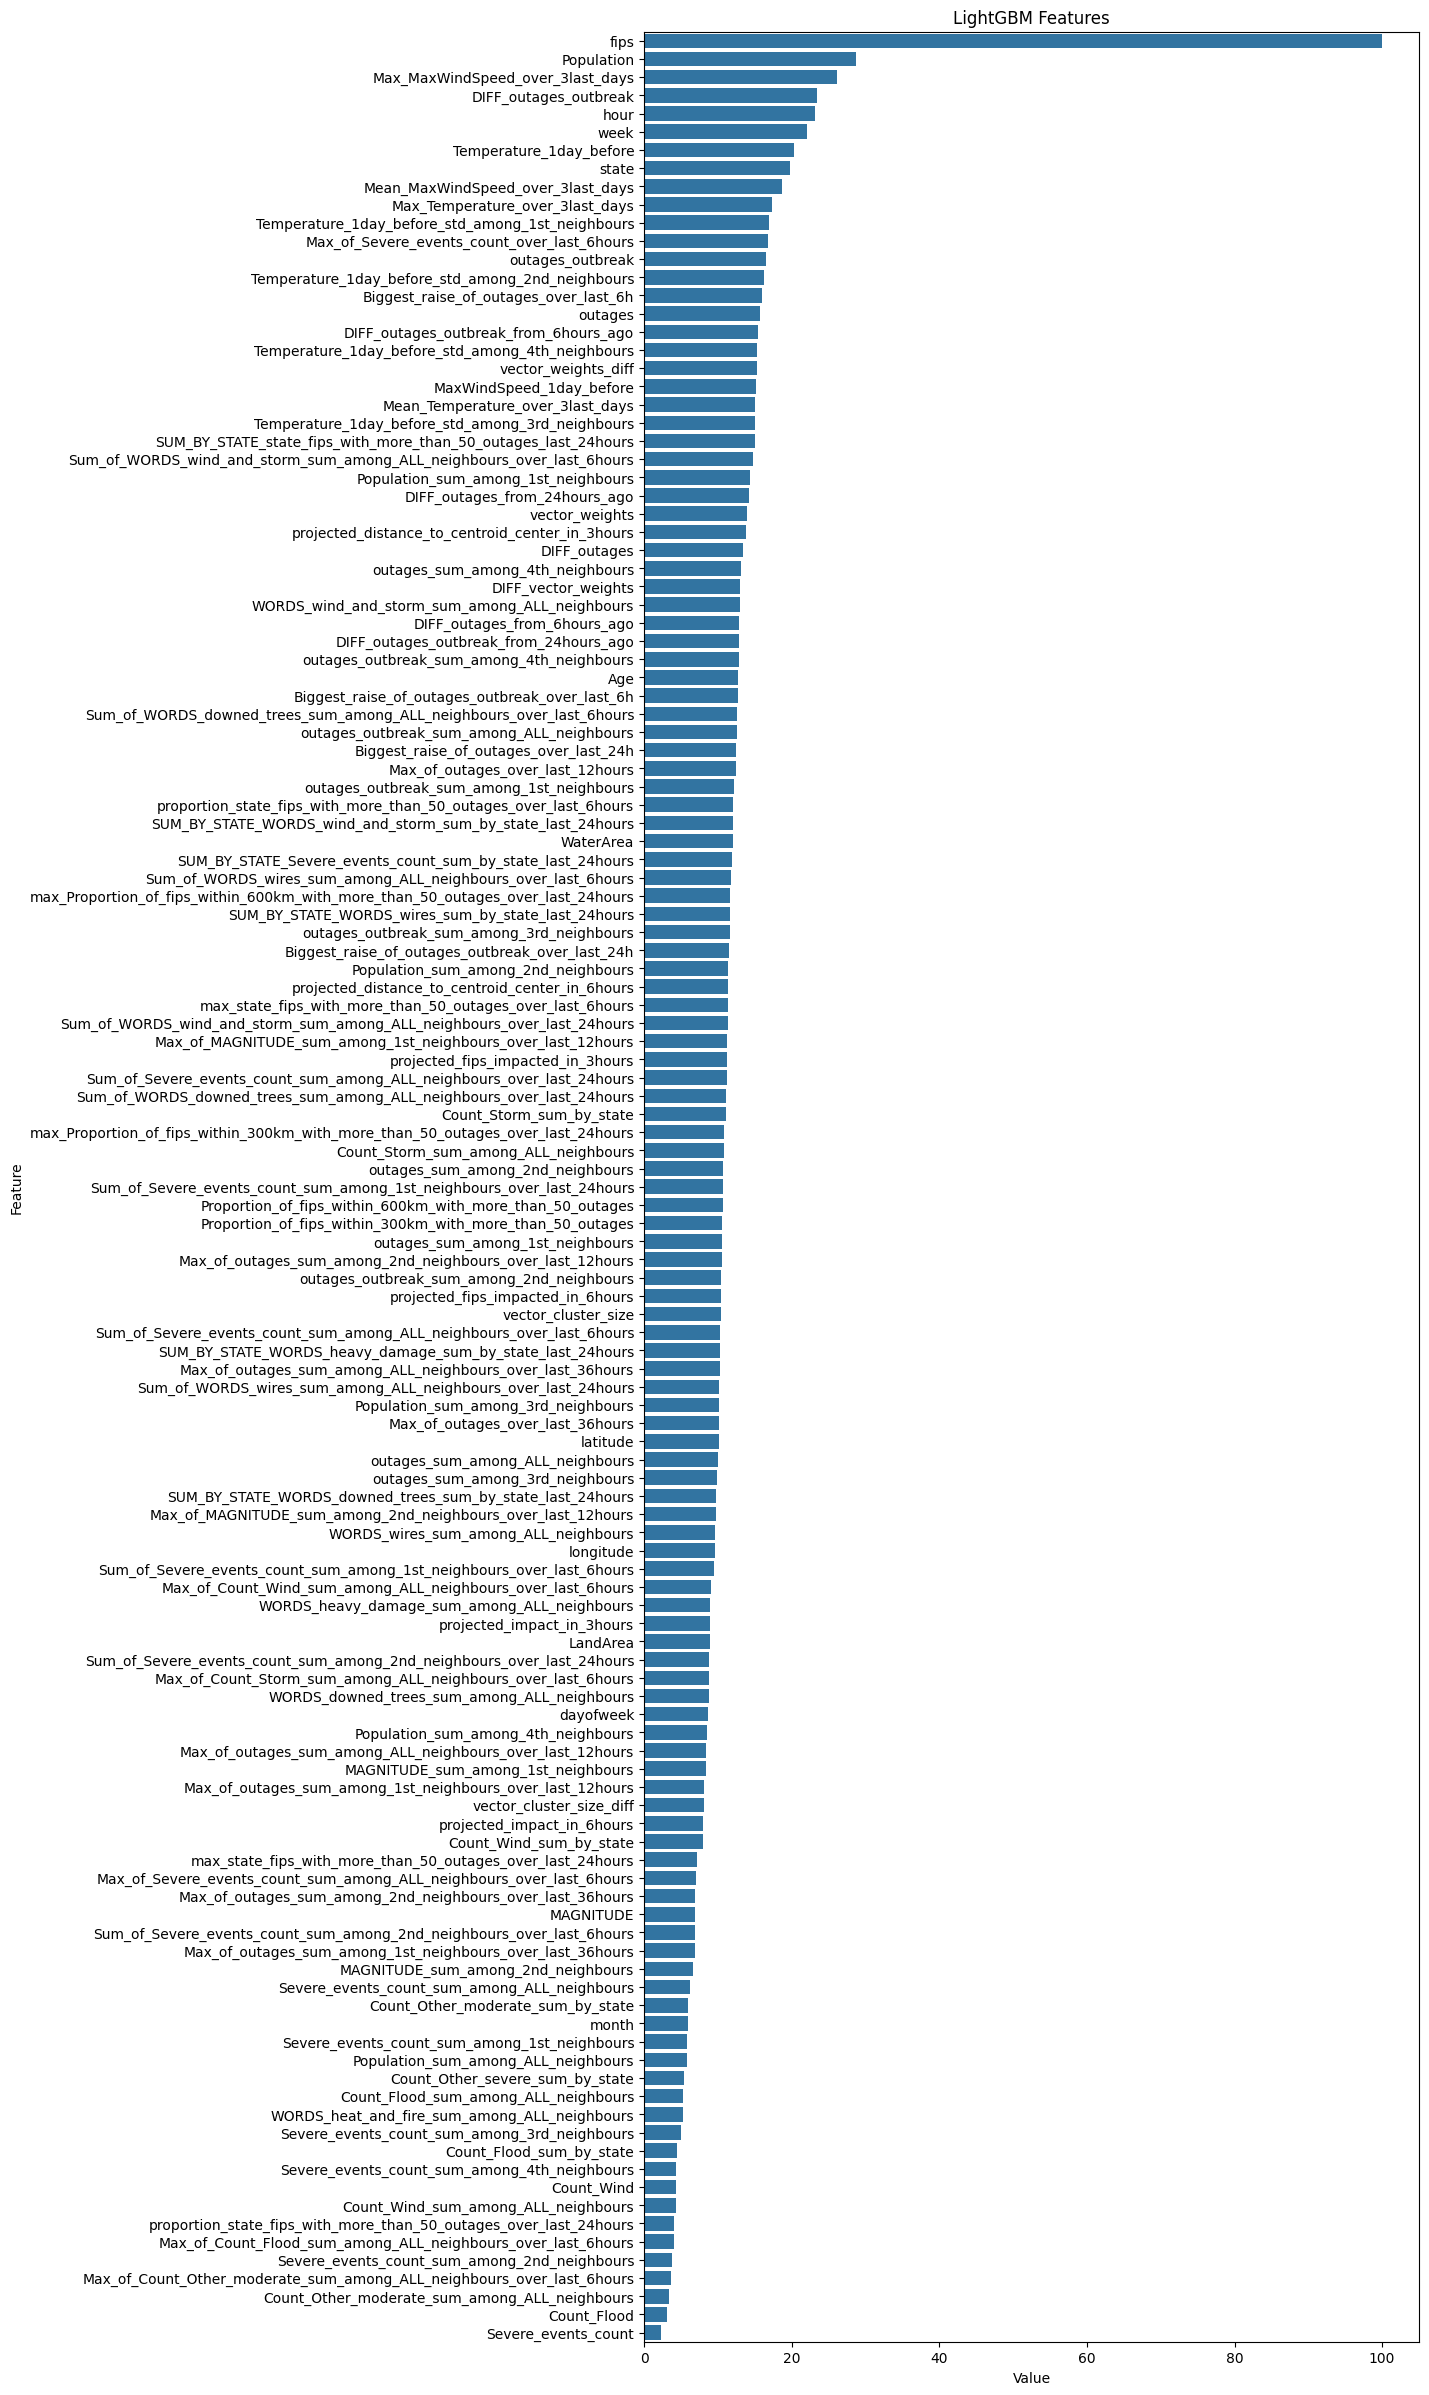

In [12]:
# Feature Importance
if evaluate_model_with_cross_validation :
    plt.figure(figsize=(10, 30))
    sns.barplot(x="Value", y="Feature", data=Feature_Imp)
    plt.title('LightGBM Features')
    plt.show()

___
___
# **Real training**
> Once the best features and model parameters have been found, we train on all rows.

In [13]:
%%time

# Train on all raws with a valid target
train_idx = (~df[target].isna())

# Train ensembles
xtr, ytr = df.loc[train_idx, feats], df.loc[train_idx, target]

# Print info
print('\n' + '-'*50)
train_period = f"{df.loc[train_idx, 'date'].astype(str).min()} => {df.loc[train_idx, 'date'].astype(str).max()}"
print(f"Train : {train_period} ({str(len(df[train_idx])).ljust(4)} rows).")
print()

# -------------------------------------------------------------------------------------------------------------------------------------------------
# Model Training

# Create model
model = lgb.LGBMRegressor(**model_params)

# Update fit parameters
fit_params["eval_set"] = [(xtr, ytr)]

# Fit model
model.fit(xtr, ytr,
          **fit_params,
          callbacks = [lgb.log_evaluation(50)])

# Save model
joblib.dump(model, "lgbm_model.joblib")


--------------------------------------------------


Train : 2019-01-01 => 2023-10-31 (15964908 rows).



[50]	training's l2: 546916	training's custom: 1419.79


[100]	training's l2: 393962	training's custom: 1188.01


[150]	training's l2: 336641	training's custom: 1097.02


[200]	training's l2: 302073	training's custom: 1040.35


CPU times: user 3h 57min 13s, sys: 1min 1s, total: 3h 58min 14s
Wall time: 5min 36s


['lgbm_model.joblib']

___
## **Feature Importances**

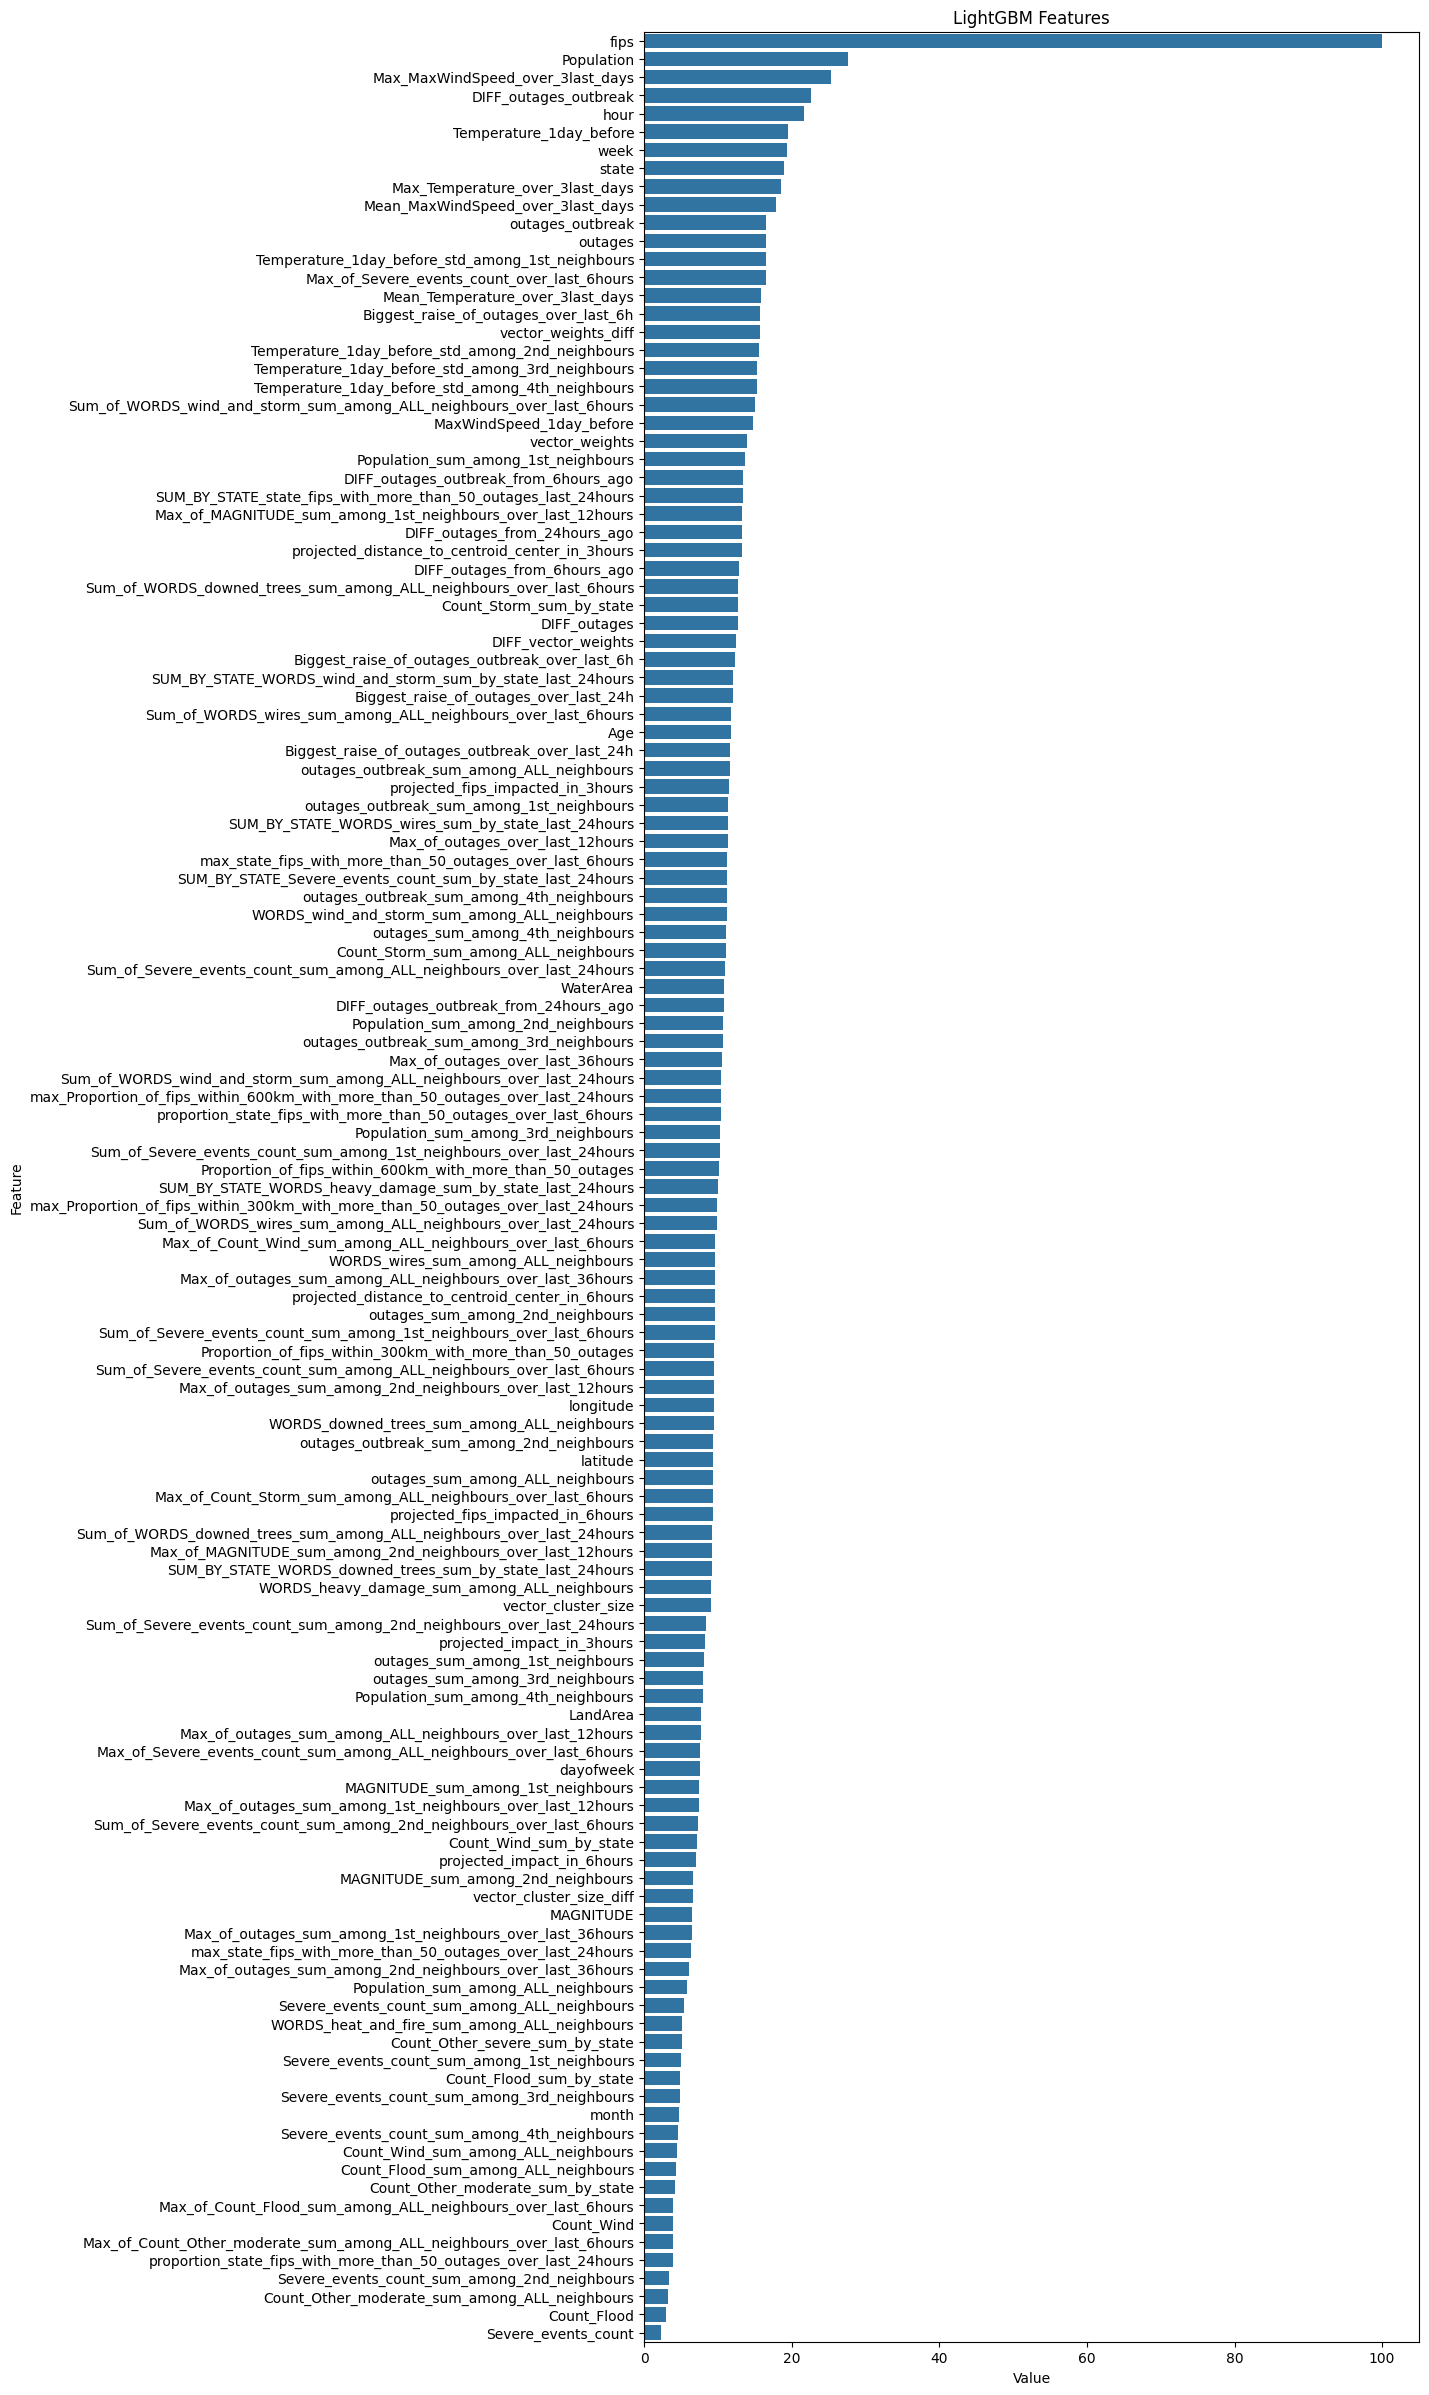

In [14]:
# Feature importance
Feature_Imp = pd.DataFrame(sorted(zip(model.feature_importances_, feats)), columns=['Value','Feature'])
Feature_Imp['Value'] = 100* (Feature_Imp['Value'] / Feature_Imp['Value'].max()) # Normalisation
Feature_Imp = Feature_Imp.sort_values(by='Value', ascending=False).reset_index(drop=True)

# Plot
plt.figure(figsize=(10, 30))
sns.barplot(x="Value", y="Feature", data=Feature_Imp)
plt.title('LightGBM Features')
plt.show()

### Most important features
- `fips code`
- `County Population`
- `Temperature` and `Wind Speed` of past days (external data)
- `Weather events` of past hours (Storms Data), for the current fips and its neighbourhood (1st to 4th adjacency-degree)
- `outages` and `outages outbreak` information (raw values, biggest raise over the last hours)
- Information in state and the neighbourhood (1st to 4th adjacency-degree): `outages sum` , `proportion of counties with more than 50 outages`
- `Project impact of outages waves in 6 hour` (estimated localisation and impact)
- `Keywords from past weather events narratives`. These features have a small forecasting value but they were interesting to use (this isn't typical).

### What could be added
- The most impactful next step would probably be to incorporate weather forecasts.
- To do so, I considered adding "severe weather events" from future rows (e.g., 24 hours ahead), but avoided it to prevent data leakage — such information would have been unrealistically accurate compared to real forecasts.
- An alternative would be to generate our own weather forecasts. Just as we modeled the direction and impact of outage waves, we could attempt to estimate the trajectory and severity of upcoming severe weather events.